<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/cv/CutMix/notebooks/Kornia_Like_Cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import Uniform
from torchvision import transforms as T
from torchvision import datasets as dsets
from torchvision.utils import make_grid

In [2]:
cifar10 = dsets.CIFAR10(
    "./dataset",
    train=True,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
    ])
)

loader = DataLoader(cifar10, batch_size=25)

Files already downloaded and verified


In [3]:
def plot_tensor(tensor, nrow=5):
    grid = make_grid(tensor, nrow=nrow)
    plt.figure(figsize=(8, 6))
    plt.imshow(grid.permute(1, 2, 0).numpy())

In [4]:
iterator = iter(loader)
inputs1, labels1 = next(iterator)
inputs2, labels2 = next(iterator)

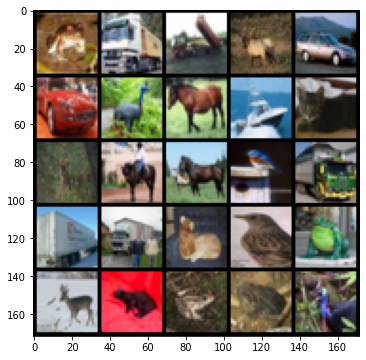

In [5]:
plot_tensor(inputs1)

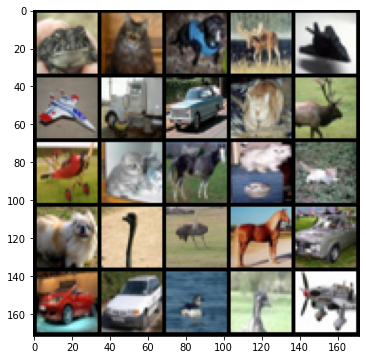

In [6]:
plot_tensor(inputs2)

In [7]:
class CutMix:
    def __init__(self, shape, warmup=50000, beta=1.0, same_on_batch=True):
        self.shape = shape
        self.beta = beta
        self.same_on_batch = same_on_batch
        self.warmup = warmup

    def __call__(self, real_images, fake_images, iteration):
        
        self._increment_cutmix_prob(iteration)
        batch_prob = self._get_batch_prob()
        is_cutmix = batch_prob < self.cutmix_prob

        lam = self._get_lambda()
        bbx1, bby1, bbx2, bby2 = self._rand_bbox(lam)
        masks = self._create_cutmix_mask(bbx1, bby1, bbx2, bby2, batch_prob)
        cutmix_tensor = self._apply_cutmix(real_images, fake_images, masks)

        return cutmix_tensor, lam, masks, is_cutmix

    def _increment_cutmix_prob(self, iteration):
        self.cutmix_prob = np.minimum(iteration * (0.5 / self.warmup), 0.5)

    def _get_batch_prob(self):
        dist = Uniform(0, 1)
        if self.same_on_batch:
            return dist.rsample((1, )).repeat(self.shape[0])
        else:
            return dist.rsample((self.shape[0], ))

    def _get_lambda(self):
        if self.same_on_batch: lam = np.random.beta(self.beta, self.beta)
        else: lam = np.random.beta(self.beta, self.beta, size=(self.shape[0], ))
        return lam

    def _rand_bbox(self, lam):
        B, C, H, W = self.shape
        cutmix_ratio = np.sqrt(1. - lam)

        cut_w = (W * cutmix_ratio).astype(np.int)
        cut_h = (H * cutmix_ratio).astype(np.int)

        if self.same_on_batch:
            cx = np.random.randint(W)
            cy = np.random.randint(H)
        else:
            cx = np.random.randint(W, size=(B,))
            cy = np.random.randint(H, size=(B,))

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

    def _create_cutmix_mask(self, bbx1, bby1, bbx2, bby2, batch_prob):

        if self.same_on_batch:
            bbx1 = np.atleast_1d(bbx1)
            bby1 = np.atleast_1d(bby1)
            bbx2 = np.atleast_1d(bbx2)
            bby2 = np.atleast_1d(bby2)

        B, _, H, W = self.shape
        masks = torch.ones(size=(B, 1, H, W), dtype=torch.long)
        for i, bbox in enumerate(zip(bbx1, bby1, bbx2, bby2)):
            if batch_prob[i] < self.cutmix_prob:
                x1, y1, x2, y2 = bbox
                if self.same_on_batch:
                    masks[:, :, x1:x2, y1:y2] = 0
                    break
                else:
                    masks[i, :, x1:x2, y1:y2] = 0

        return masks

    def _apply_cutmix(self, real_images, fake_images, masks):

        fake_rand_idx = torch.randperm(len(fake_images))
        fake_images = fake_images[fake_rand_idx]

        if self.same_on_batch:
            apply_mask = masks[0, None, ...]
            cutmix_tensor = real_images * apply_mask + (1 - apply_mask) * fake_images
        else:
            cutmix_tensor = [real_images[i] * mask + fake_images[i] * (1 - mask) \
                            for i, mask in enumerate(masks)]
            cutmix_tensor = torch.stack(cutmix_tensor, dim=0)

        return cutmix_tensor

<class 'torch.Tensor'>
<class 'float'>
<class 'torch.Tensor'>
0.5
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])


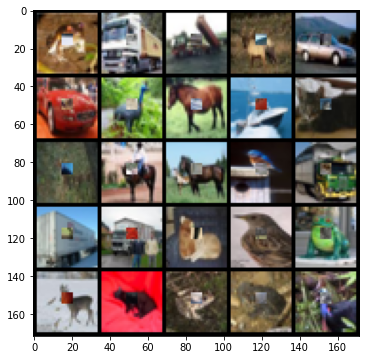

In [10]:
cutmix_aug = CutMix(inputs1.shape, warmup=1, beta=1.0, same_on_batch=True)
mix_tensor, lam, masks, is_cutmix = cutmix_aug(inputs1, inputs2, iteration=1)

print(type(mix_tensor))
print(type(lam))
print(type(masks))
print(cutmix_aug.cutmix_prob)
print(is_cutmix)

plot_tensor(mix_tensor)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
0.5
tensor([ True, False,  True, False, False,  True, False, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False,  True, False,  True, False])


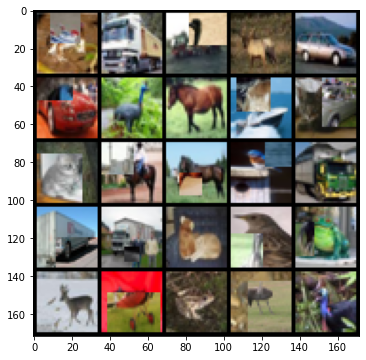

In [11]:
cutmix_aug = CutMix(inputs1.shape, warmup=1, beta=1.0, same_on_batch=False)
mix_tensor, lam, masks, is_cutmix = cutmix_aug(inputs1, inputs2, iteration=1)

print(type(mix_tensor))
print(type(lam))
print(type(masks))
print(cutmix_aug.cutmix_prob)
print(is_cutmix)

plot_tensor(mix_tensor)

In [12]:
%timeit CutMix(inputs1.shape, warmup=1, beta=1.0, same_on_batch=True)(inputs1, inputs2, iteration=1)

1000 loops, best of 3: 825 µs per loop


In [13]:
%timeit CutMix(inputs2.shape, warmup=1, beta=1.0, same_on_batch=False)(inputs1, inputs2, iteration=1)

100 loops, best of 3: 2.41 ms per loop
